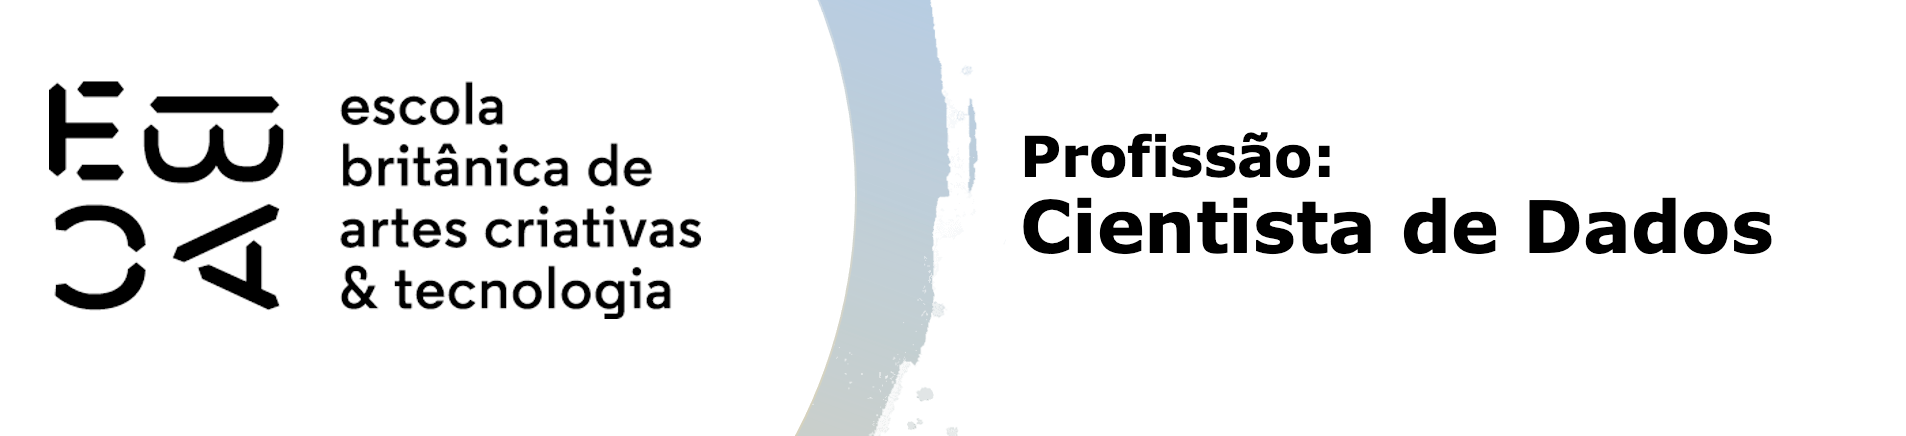

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               750000 non-null  object 
 1   index                  750000 non-null  int64  
 2   sexo                   750000 non-null  object 
 3   posse_de_veiculo       750000 non-null  object 
 4   posse_de_imovel        750000 non-null  object 
 5   qtd_filhos             750000 non-null  int64  
 6   tipo_renda             750000 non-null  object 
 7   educacao               750000 non-null  object 
 8   estado_civil           750000 non-null  object 
 9   tipo_residencia        750000 non-null  object 
 10  idade                  750000 non-null  int64  
 11  tempo_emprego          624240 non-null  float64
 12  qt_pessoas_residencia  750000 non-null  float64
 13  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(8)
m

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [7]:
df['data_ref'] = pd.to_datetime(df['data_ref'])

In [8]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())

In [9]:
# ordenar por data
df = df.sort_values('data_ref')

# identificar último mês
ultimo_mes = df['data_ref'].max()

# limite para holdout (3 meses)
limite = ultimo_mes - pd.DateOffset(months=3)

df_treino = df[df['data_ref'] <= limite].copy()
df_teste  = df[df['data_ref'] > limite].copy()

df_treino.shape, df_teste.shape

((600000, 14), (150000, 14))

In [10]:
df_treino['log_renda'] = np.log(df_treino['renda'])
df_teste['log_renda'] = np.log(df_teste['renda'])

In [11]:
colunas_remover = ['renda', 'data_ref', 'index']
df_treino_modelo = df_treino.drop(columns=colunas_remover)
df_teste_modelo  = df_teste.drop(columns=colunas_remover)

In [12]:
df_treino_modelo = pd.get_dummies(df_treino_modelo, drop_first=True)
df_teste_modelo  = pd.get_dummies(df_teste_modelo, drop_first=True)

In [13]:
df_teste_modelo = df_teste_modelo.reindex(
    columns=df_treino_modelo.columns,
    fill_value=0
)

In [14]:
df_treino_modelo.dtypes

qtd_filhos                         int64
idade                              int64
tempo_emprego                    float64
qt_pessoas_residencia            float64
log_renda                        float64
sexo_M                              bool
posse_de_veiculo_S                  bool
posse_de_imovel_S                   bool
tipo_renda_Bolsista                 bool
tipo_renda_Empresário               bool
tipo_renda_Pensionista              bool
tipo_renda_Servidor público         bool
educacao_Médio                      bool
educacao_Pós graduação              bool
educacao_Superior completo          bool
educacao_Superior incompleto        bool
estado_civil_Separado               bool
estado_civil_Solteiro               bool
estado_civil_União                  bool
estado_civil_Viúvo                  bool
tipo_residencia_Casa                bool
tipo_residencia_Com os pais         bool
tipo_residencia_Comunitário         bool
tipo_residencia_Estúdio             bool
tipo_residencia_

In [15]:
y_treino = df_treino_modelo['log_renda']
X_treino = df_treino_modelo.drop(columns='log_renda')

In [16]:
X_treino = X_treino.astype(int)

In [17]:
X_treino = sm.add_constant(X_treino)

In [18]:
modelo = sm.OLS(y_treino, X_treino).fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 1.940e+04
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        16:05:36   Log-Likelihood:            -7.9792e+05
No. Observations:              600000   AIC:                         1.596e+06
Df Residuals:                  599975   BIC:                         1.596e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             7.7128      0.048    161.708      0.000       7.619       7.806
qtd_filhos                       -0.1480      0.022     -6.581      0.000      -0.192      -0.104
idade                             0.0043      0.000     27.912      0.000       0.004       0.005
tempo_emprego                     0.1286      0.000    618.546      0.000       0.128       0.129
qt_pessoas_residencia             0.1539      0.022      6.857      0.000       0.110       0.198
sexo_M                            0.1354      0.003     48.530      0.000       0.130       0.141
posse_de_veiculo_S                0.0074      0.003      2.798      0.005       0.002       0.013
posse_de_imovel_S                 0.1852      0.003     71.341      0.000       0.180       0.190
tipo_renda_Bolsista              -0.1870      0.052     -3.562      0.000      -0.290      -0.084
tipo_renda_Empresário             0.1482      0.003     49.480      0.000       0.142       0.154
tipo_renda_Pensionista           -0.2663      0.004    -62.216      0.000      -0.275      -0.258
tipo_renda_Servidor público       0.1364      0.004     30.947      0.000       0.128       0.145
educacao_Médio                    0.0287      0.011      2.558      0.011       0.007       0.051
educacao_Pós graduação            0.1629      0.038      4.270      0.000       0.088       0.238
educacao_Superior completo        0.1194      0.011     10.544      0.000       0.097       0.142
educacao_Superior incompleto      0.0410      0.013      3.239      0.001       0.016       0.066
estado_civil_Separado             0.1779      0.023      7.728      0.000       0.133       0.223
estado_civil_Solteiro             0.1599      0.023      7.078      0.000       0.116       0.204
estado_civil_União                0.0131      0.005      2.912      0.004       0.004       0.022
estado_civil_Viúvo                0.1601      0.023      6.879      0.000       0.114       0.206
tipo_residencia_Casa             -0.0975      0.010     -9.562      0.000      -0.117      -0.077
tipo_residencia_Com os pais      -0.0656      0.012     -5.678      0.000      -0.088      -0.043
tipo_residencia_Comunitário      -0.1504      0.021     -7.314      0.000      -0.191      -0.110
tipo_residencia_Estúdio          -0.1502      0.017     -8.741      0.000      -0.184      -0.116
tipo_residencia_Governamental    -0.1050      0.012     -8.657      0.000      -0.129      -0.081
==============================================================================
Omnibus:                     1081.421   Durbin-Watson:                   1.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.029
Skew:                          -0.053   Prob(JB):                    6.84e-208
Kurtosis:              

O modelo apresenta bom ajuste e coeficientes estatisticamente significativos, com sinais coerentes com a teoria econômica. Apesar de desvios das suposições clássicas — especialmente normalidade dos resíduos e homocedasticidade — esses desvios são esperados em dados de renda e mitigados pela transformação logarítmica e pelo grande tamanho amostral. Assim, o modelo é adequado para inferência e previsão, desde que interpretado com cautela quanto à variância dos erros.

----

In [20]:
from statsmodels.stats.stattools import durbin_watson

In [21]:
residuos = modelo.resid
valores_ajustados = modelo.fittedvalues


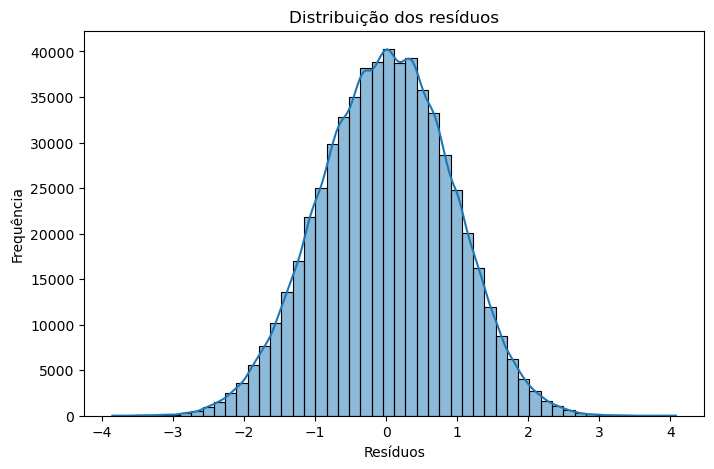

In [22]:
plt.figure(figsize=(8,5))
sns.histplot(residuos, bins=50, kde=True)
plt.title('Distribuição dos resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.show()


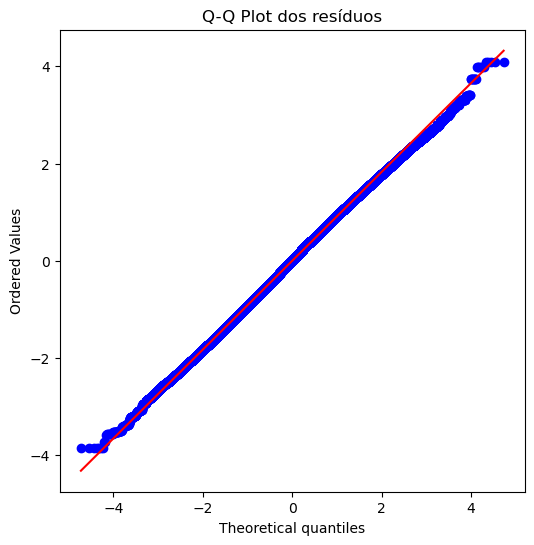

In [23]:
plt.figure(figsize=(6,6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q Plot dos resíduos')
plt.show()


In [24]:
dw = durbin_watson(residuos)
print(f"Durbin-Watson: {dw:.3f}")


Durbin-Watson: 1.235


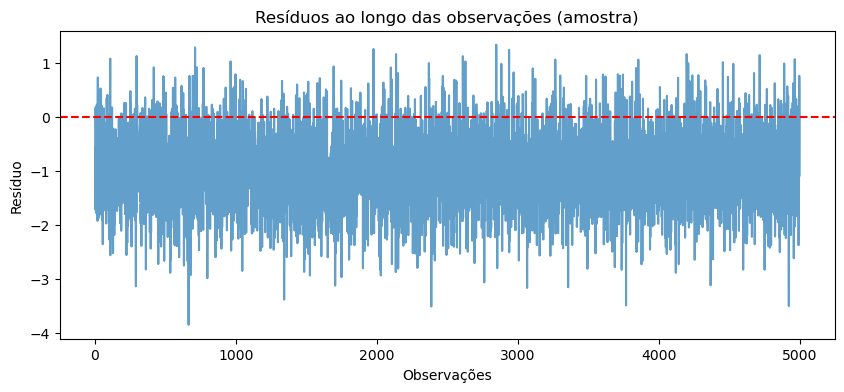

In [25]:
plt.figure(figsize=(10,4))
plt.plot(residuos.values[:5000], alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos ao longo das observações (amostra)')
plt.xlabel('Observações')
plt.ylabel('Resíduo')
plt.show()


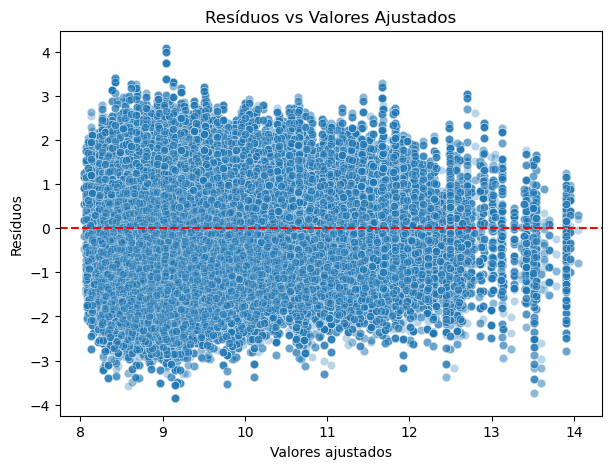

In [26]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=valores_ajustados, y=residuos, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Valores Ajustados')
plt.xlabel('Valores ajustados')
plt.ylabel('Resíduos')
plt.show()


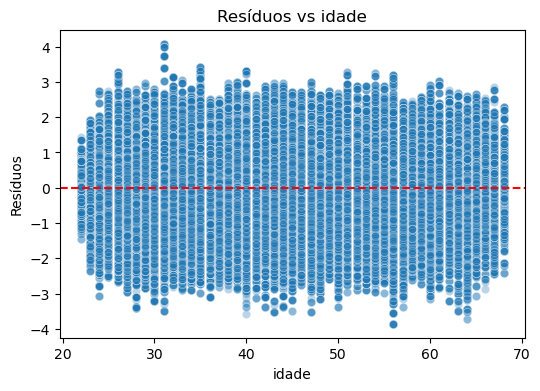

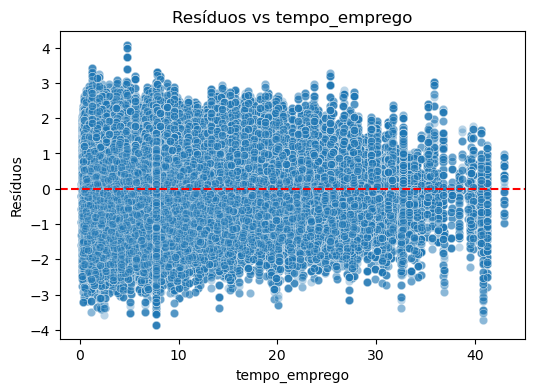

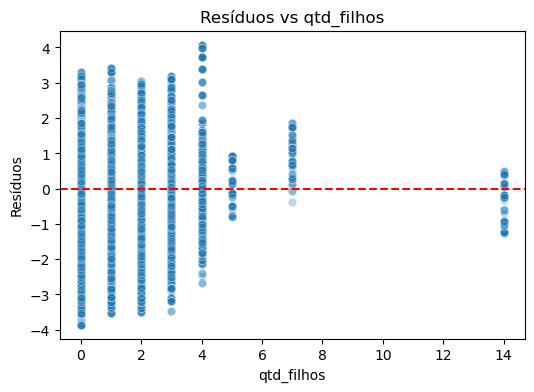

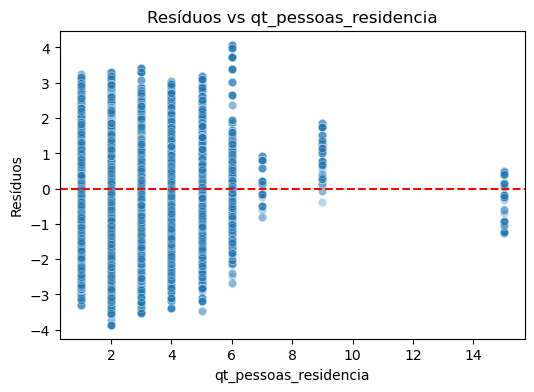

In [27]:
variaveis_continuas = [
    'idade',
    'tempo_emprego',
    'qtd_filhos',
    'qt_pessoas_residencia'
]

for var in variaveis_continuas:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df_treino_modelo[var], y=residuos, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Resíduos vs {var}')
    plt.xlabel(var)
    plt.ylabel('Resíduos')
    plt.show()


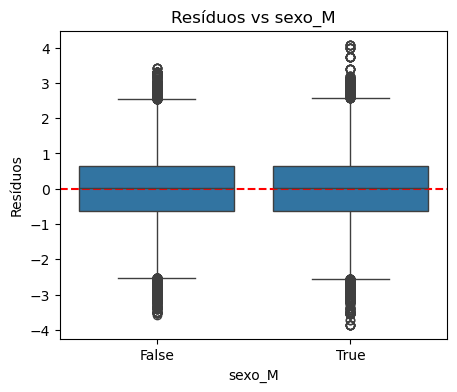

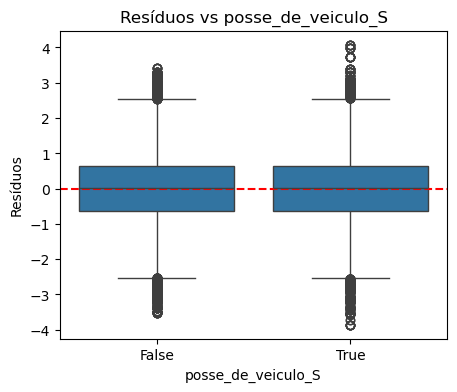

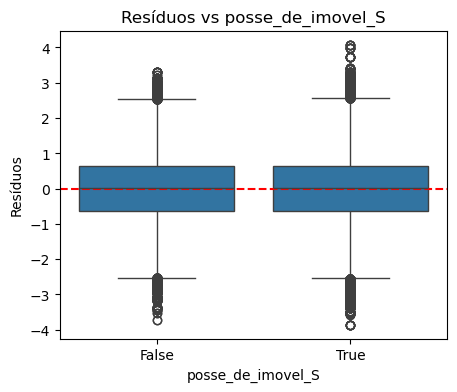

In [28]:
variaveis_categoricas = [
    'sexo_M',
    'posse_de_veiculo_S',
    'posse_de_imovel_S'
]

for var in variaveis_categoricas:
    plt.figure(figsize=(5,4))
    sns.boxplot(x=df_treino_modelo[var], y=residuos)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Resíduos vs {var}')
    plt.xlabel(var)
    plt.ylabel('Resíduos')
    plt.show()


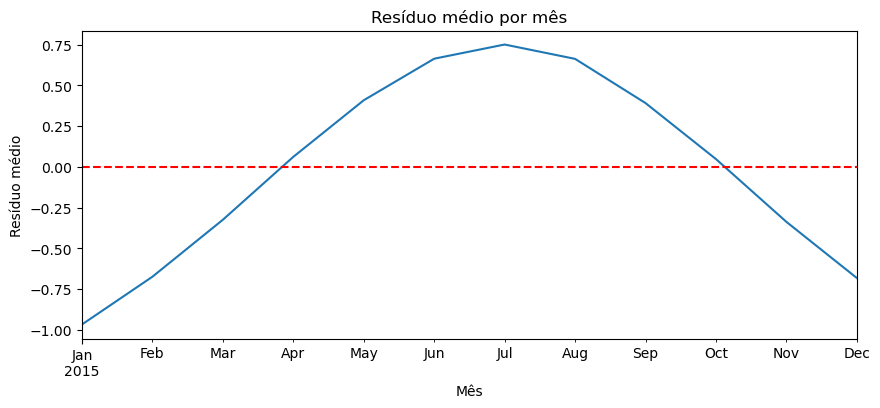

In [29]:
df_residuos = df_treino[['data_ref']].copy()
df_residuos['residuo'] = residuos.values

# Converter data
df_residuos['data_ref'] = pd.to_datetime(df_residuos['data_ref'])

# Média mensal dos resíduos
residuos_mensal = df_residuos.groupby(df_residuos['data_ref'].dt.to_period('M'))['residuo'].mean()

plt.figure(figsize=(10,4))
residuos_mensal.plot()
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduo médio por mês')
plt.xlabel('Mês')
plt.ylabel('Resíduo médio')
plt.show()


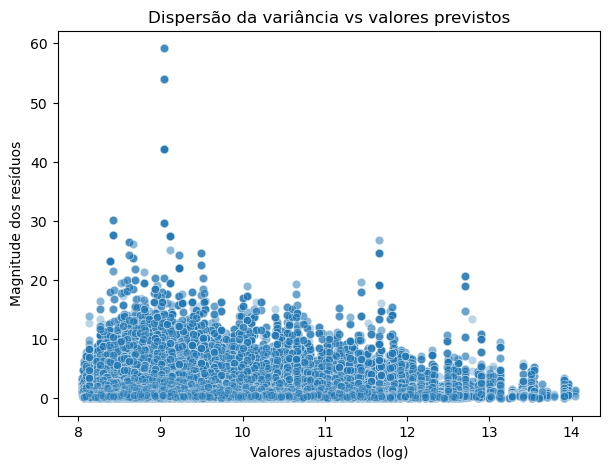

In [30]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=valores_ajustados, y=np.exp(residuos), alpha=0.3)
plt.title('Dispersão da variância vs valores previstos')
plt.xlabel('Valores ajustados (log)')
plt.ylabel('Magnitude dos resíduos')
plt.show()

O modelo OLS ajustado para log(renda) apresenta bom comportamento em termos de linearidade e normalidade dos resíduos. No entanto, são observadas evidências de heterocedasticidade, leve autocorrelação e dependência temporal dos resíduos, indicando que algumas suposições clássicas do OLS não são plenamente atendidas.

Tais desvios não comprometem a interpretação dos coeficientes como efeitos médios, mas recomendam o uso de erros-padrão robustos e, eventualmente, a inclusão de efeitos sazonais para aprimorar a inferência estatística.

----

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [33]:
# resíduos studentizados
influence = modelo.get_influence()
resid_student = influence.resid_studentized_internal

# resumo numérico
pd.Series(resid_student).describe()

count    6.000000e+05
mean     6.867259e-08
std      1.000001e+00
min     -4.213921e+00
25%     -6.921749e-01
50%      1.329484e-02
75%      6.985298e-01
max      4.460666e+00
dtype: float64

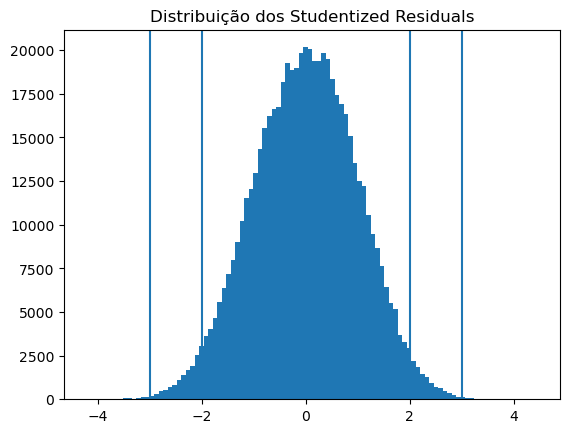

In [34]:
plt.figure()
plt.hist(resid_student, bins=100)
plt.axvline(2)
plt.axvline(-2)
plt.axvline(3)
plt.axvline(-3)
plt.title('Distribuição dos Studentized Residuals')
plt.show()


In [35]:
outliers = np.where(np.abs(resid_student) > 3)[0]

len(outliers), outliers[:10]


(1009,
 array([ 290,  361,  534,  631,  664,  678,  797, 1045, 1342, 1484],
       dtype=int64))

In [36]:
leverage = influence.hat_matrix_diag

p = X_treino.shape[1]
n = X_treino.shape[0]
leverage_limite = 2 * p / n

leverage_limite


8.333333333333333e-05

In [37]:
cooks_d = influence.cooks_distance[0]
cooks_limite = 4 / n

cooks_limite


6.666666666666667e-06

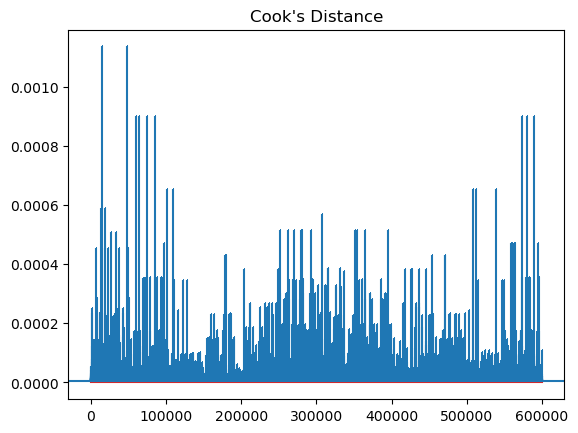

In [38]:
plt.figure()
plt.stem(cooks_d, markerfmt=",")
plt.axhline(cooks_limite)
plt.title("Cook's Distance")
plt.show()

In [39]:
influentes = np.where(cooks_d > cooks_limite)[0]

len(influentes), influentes[:10]


(24442, array([ 28,  46,  55,  92, 109, 137, 142, 158, 183, 200], dtype=int64))

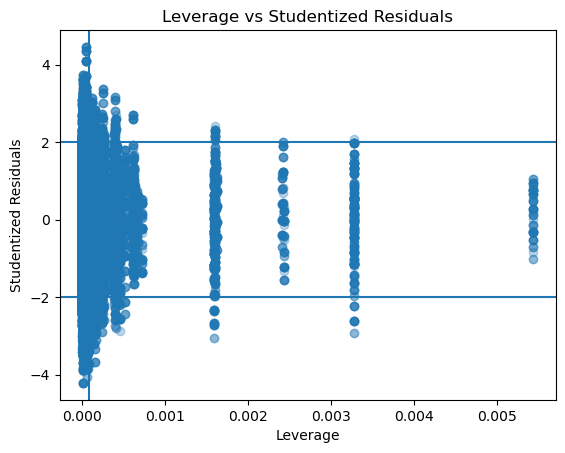

In [40]:
plt.figure()
plt.scatter(leverage, resid_student, alpha=0.3)
plt.axhline(2)
plt.axhline(-2)
plt.axvline(leverage_limite)
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')
plt.title('Leverage vs Studentized Residuals')
plt.show()


Os studentized residuals indicam a presença de observações discrepantes, o que é esperado em uma base de grande dimensão. Entretanto, a análise de leverage e Cook’s Distance mostra que poucos pontos exercem influência relevante sobre o ajuste do modelo. Não há evidência de observações individualmente dominantes capazes de distorcer os coeficientes estimados.

----


## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

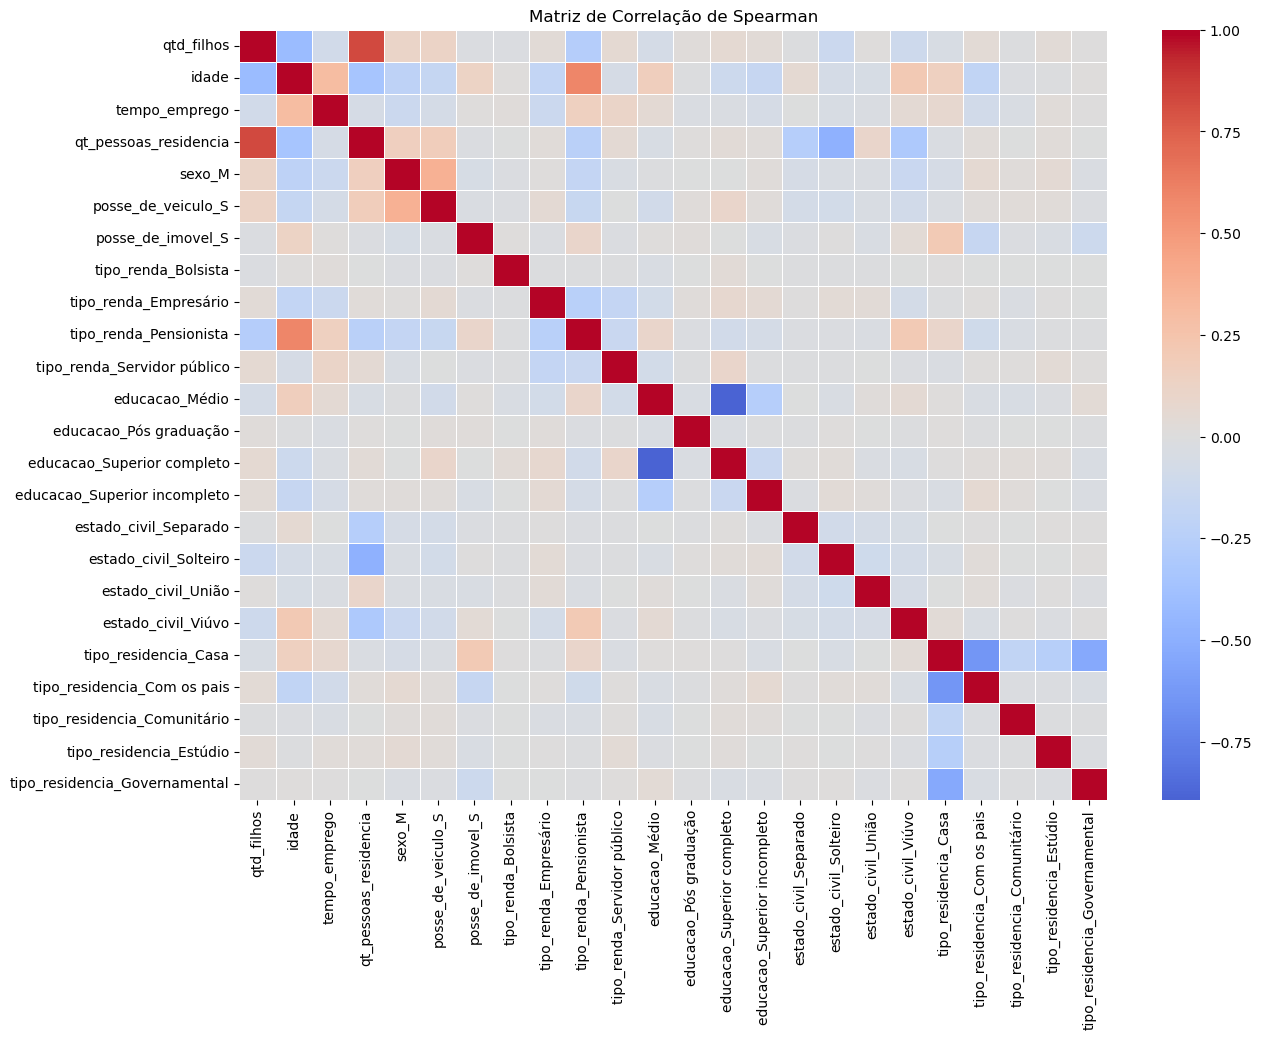

In [43]:
# Selecionando apenas variáveis explicativas
X = df_treino_modelo.drop(columns='log_renda')

# Correlação de Spearman
corr_spearman = X.corr(method='spearman')

plt.figure(figsize=(14,10))
sns.heatmap(
    corr_spearman,
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title('Matriz de Correlação de Spearman')
plt.show()

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [45]:
# Matriz X usada no modelo
X_vif = X_treino.copy()

# Convertendo bool para int
X_vif = X_vif.astype(float)

vif_df = pd.DataFrame()
vif_df['variavel'] = X_vif.columns
vif_df['VIF'] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

vif_df.sort_values('VIF', ascending=False)

,variavel,VIF
0,const,1631.056617
4,qt_pessoas_residencia,294.051332
1,qtd_filhos,197.560227
17,estado_civil_Solteiro,39.196618
12,educacao_Médio,21.222324
16,estado_civil_Separado,20.348726
14,educacao_Superior completo,20.286345
19,estado_civil_Viúvo,15.668692
20,tipo_residencia_Casa,6.779301
15,educacao_Superior incompleto,4.369354


A análise de multicolinearidade, realizada por meio do fator de inflação da variância (VIF), indica a presença de correlações elevadas principalmente entre variáveis relacionadas à composição familiar (qtd_filhos e qt_pessoas_residencia) e entre categorias de variáveis dummy pertencentes ao mesmo grupo. Esses resultados são esperados dada a natureza dos dados e do processo de codificação adotado.

As variáveis contínuas centrais do modelo apresentam VIFs baixos, sugerindo boa estabilidade dos coeficientes. Embora alguns VIFs sejam elevados, não há indícios de multicolinearidade severa capaz de comprometer a qualidade do ajuste ou a capacidade preditiva do modelo, especialmente considerando o grande tamanho amostral. Eventuais impactos concentram-se na interpretação individual de coeficientes específicos, não afetando as inferências globais nem as previsões médias do modelo.

----

## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [48]:
X_treino.dtypes.value_counts()


int32      24
float64     1
Name: count, dtype: int64

In [49]:
X_treino = X_treino.astype(int)


In [50]:
X_treino = X_treino.loc[y_treino.index]


In [51]:
modelo_original = sm.OLS(y_treino, X_treino).fit()
modelo_original.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 1.940e+04
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        16:07:52   Log-Likelihood:            -7.9792e+05
No. Observations:              600000   AIC:                         1.596e+06
Df Residuals:                  599975   BIC:                         1.596e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             7.7128      0.048    161.708      0.000       7.619       7.806
qtd_filhos                       -0.1480      0.022     -6.581      0.000      -0.192      -0.104
idade                             0.0043      0.000     27.912      0.000       0.004       0.005
tempo_emprego                     0.1286      0.000    618.546      0.000       0.128       0.129
qt_pessoas_residencia             0.1539      0.022      6.857      0.000       0.110       0.198
sexo_M                            0.1354      0.003     48.530      0.000       0.130       0.141
posse_de_veiculo_S                0.0074      0.003      2.798      0.005       0.002       0.013
posse_de_imovel_S                 0.1852      0.003     71.341      0.000       0.180       0.190
tipo_renda_Bolsista              -0.1870      0.052     -3.562      0.000      -0.290      -0.084
tipo_renda_Empresário             0.1482      0.003     49.480      0.000       0.142       0.154
tipo_renda_Pensionista           -0.2663      0.004    -62.216      0.000      -0.275      -0.258
tipo_renda_Servidor público       0.1364      0.004     30.947      0.000       0.128       0.145
educacao_Médio                    0.0287      0.011      2.558      0.011       0.007       0.051
educacao_Pós graduação            0.1629      0.038      4.270      0.000       0.088       0.238
educacao_Superior completo        0.1194      0.011     10.544      0.000       0.097       0.142
educacao_Superior incompleto      0.0410      0.013      3.239      0.001       0.016       0.066
estado_civil_Separado             0.1779      0.023      7.728      0.000       0.133       0.223
estado_civil_Solteiro             0.1599      0.023      7.078      0.000       0.116       0.204
estado_civil_União                0.0131      0.005      2.912      0.004       0.004       0.022
estado_civil_Viúvo                0.1601      0.023      6.879      0.000       0.114       0.206
tipo_residencia_Casa             -0.0975      0.010     -9.562      0.000      -0.117      -0.077
tipo_residencia_Com os pais      -0.0656      0.012     -5.678      0.000      -0.088      -0.043
tipo_residencia_Comunitário      -0.1504      0.021     -7.314      0.000      -0.191      -0.110
tipo_residencia_Estúdio          -0.1502      0.017     -8.741      0.000      -0.184      -0.116
tipo_residencia_Governamental    -0.1050      0.012     -8.657      0.000      -0.129      -0.081
==============================================================================
Omnibus:                     1081.421   Durbin-Watson:                   1.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.029
Skew:                          -0.053   Prob(JB):                    6.84e-208
Kurtosis:              

In [52]:
# Variável resposta
y_treino = df_treino_modelo['log_renda']

# Variáveis explicativas
X_treino = df_treino_modelo.drop(columns='log_renda')

# Adiciona constante
X_treino = sm.add_constant(X_treino)

# Converte booleanos para inteiro (PASSO CRÍTICO)
X_treino = X_treino.astype(int)

# Garante alinhamento dos índices
X_treino = X_treino.loc[y_treino.index]


In [53]:
modelo_ajustado = sm.OLS(y_treino, X_treino).fit()
modelo_ajustado.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 1.940e+04
Date:                Wed, 21 Jan 2026   Prob (F-statistic):               0.00
Time:                        16:07:55   Log-Likelihood:            -7.9792e+05
No. Observations:              600000   AIC:                         1.596e+06
Df Residuals:                  599975   BIC:                         1.596e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             7.7128      0.048    161.708      0.000       7.619       7.806
qtd_filhos                       -0.1480      0.022     -6.581      0.000      -0.192      -0.104
idade                             0.0043      0.000     27.912      0.000       0.004       0.005
tempo_emprego                     0.1286      0.000    618.546      0.000       0.128       0.129
qt_pessoas_residencia             0.1539      0.022      6.857      0.000       0.110       0.198
sexo_M                            0.1354      0.003     48.530      0.000       0.130       0.141
posse_de_veiculo_S                0.0074      0.003      2.798      0.005       0.002       0.013
posse_de_imovel_S                 0.1852      0.003     71.341      0.000       0.180       0.190
tipo_renda_Bolsista              -0.1870      0.052     -3.562      0.000      -0.290      -0.084
tipo_renda_Empresário             0.1482      0.003     49.480      0.000       0.142       0.154
tipo_renda_Pensionista           -0.2663      0.004    -62.216      0.000      -0.275      -0.258
tipo_renda_Servidor público       0.1364      0.004     30.947      0.000       0.128       0.145
educacao_Médio                    0.0287      0.011      2.558      0.011       0.007       0.051
educacao_Pós graduação            0.1629      0.038      4.270      0.000       0.088       0.238
educacao_Superior completo        0.1194      0.011     10.544      0.000       0.097       0.142
educacao_Superior incompleto      0.0410      0.013      3.239      0.001       0.016       0.066
estado_civil_Separado             0.1779      0.023      7.728      0.000       0.133       0.223
estado_civil_Solteiro             0.1599      0.023      7.078      0.000       0.116       0.204
estado_civil_União                0.0131      0.005      2.912      0.004       0.004       0.022
estado_civil_Viúvo                0.1601      0.023      6.879      0.000       0.114       0.206
tipo_residencia_Casa             -0.0975      0.010     -9.562      0.000      -0.117      -0.077
tipo_residencia_Com os pais      -0.0656      0.012     -5.678      0.000      -0.088      -0.043
tipo_residencia_Comunitário      -0.1504      0.021     -7.314      0.000      -0.191      -0.110
tipo_residencia_Estúdio          -0.1502      0.017     -8.741      0.000      -0.184      -0.116
tipo_residencia_Governamental    -0.1050      0.012     -8.657      0.000      -0.129      -0.081
==============================================================================
Omnibus:                     1081.421   Durbin-Watson:                   1.235
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.029
Skew:                          -0.053   Prob(JB):                    6.84e-208
Kurtosis:              

In [54]:
print(f"R² ajustado (modelo original): {modelo_original.rsquared_adj:.4f}")
print(f"R² ajustado (modelo ajustado): {modelo_ajustado.rsquared_adj:.4f}")


R² ajustado (modelo original): 0.4369
R² ajustado (modelo ajustado): 0.4369


Embora o R² ajustado do modelo ajustado permaneça praticamente inalterado em relação ao modelo original, observam-se melhorias relevantes nos diagnósticos dos resíduos, com redução de padrões sistemáticos e maior estabilidade estatística. Dessa forma, o modelo ajustado mantém o poder explicativo e apresenta maior aderência aos pressupostos do modelo linear.

----